# Module 1 — Hands-On 1.7 (B): Housing Regression (Price)
**Goal:** Apply the ML pipeline to a small dataset.

**Steps:** load → minimal EDA/cleaning → split → simple model → metrics (RMSE/R²).

## Step 1: Load the Dataset

### Understanding the Synthetic Housing Dataset

If the (`data/housing_synth.csv`) isn’t found, we generate a small **synthetic housing dataset** so you can complete the exercise without extra downloads.

This dataset contains **360 rows** (records), each representing a single house.  
It includes a mix of **numeric features** and one **target variable** (`price`) for regression.

---

**Columns and their meanings**

| Column | Type | Description |
|---------|------|-------------|
| **`sqft`** | Numeric (int) | Size of the house in square feet. Larger homes generally have higher prices. |
| **`bedrooms`** | Numeric (int) | Number of bedrooms. Often increases price, but not always linearly. |
| **`bathrooms`** | Numeric (int) | Number of bathrooms. Can be correlated with house size and quality. |
| **`age_years`** | Numeric (int) | Approximate age of the house in years. Older homes may cost less unless recently renovated. |
| **`lot_size`** | Numeric (float) | Size of the property lot (in acres or hectares). Affects land value. |
| **`dist_to_center_km`** | Numeric (float) | Distance from the city center (in kilometers). Prices usually decrease as distance increases. |
| **`price`** | Numeric (float) | The **target variable** — the home’s selling price in dollars. The model will learn to predict this value. |

We use a **random number generator** seeded with `SEED = 1955` to ensure reproducibility.  
That means everyone running this notebook gets the *same exact numbers*.

In [2]:
import pandas as pd
import numpy as np

SEED = 1955
try:
    df = pd.read_csv('../data/housing_synth.csv')
except FileNotFoundError:
    rng = np.random.default_rng(SEED)
    df = pd.DataFrame({
        'sqft': rng.integers(400, 3000, 360),
        'bedrooms': rng.integers(1, 6, 360),
        'bathrooms': rng.integers(1, 4, 360),
        'age_years': rng.integers(0, 100, 360),
        'lot_size': rng.uniform(0.05, 0.5, 360).round(3),
        'dist_to_center_km': rng.uniform(0.5, 30, 360).round(2),
        'price': rng.normal(300000, 60000, 360).round(0)
    })
df.head()

,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,1338,2,1,5,0.351,29.93,180619.0
1,853,3,2,72,0.252,23.88,380214.0
2,2081,3,1,28,0.405,26.82,328780.0
3,475,4,2,25,0.421,14.11,358725.0
4,2113,4,2,45,0.194,26.32,266528.0


### Introducing realistic “messiness”

- **Missing `sqft` / `lot_size`**: practice **imputation** strategies (median vs mean) and consider their implications.
- **Improbable values** (`sqft` ≤ 0 or extremely large): practice **data validation rules** (e.g., clip, drop, or re-collect).

In production, you’d confirm corrections with domain experts. In this lab, we’ll apply simple, transparent rules (e.g., set negative/zero `sqft` to `NaN` and then impute).


What messiness was injected below:
- sqft — NaNs, values ≤0, huge outlier
- lot_size — NaNs, tiny & huge outliers
- dist_to_center_km — non-positive and huge outlier
- bedrooms/bathrooms — zero/negative counts
- age_years — negative and too large
- price — NaNs and extreme outliers

In [3]:
# --- Inject realistic messiness for hands-on cleaning (Housing) ---
import numpy as np

SEED = 1955
rng = np.random.default_rng(SEED)

n = len(df)

# Ensure expected numeric columns exist (if you generated the synthetic set)
expected = ['sqft','bedrooms','bathrooms','age_years','lot_size','dist_to_center_km','price']
missing_cols = [c for c in expected if c not in df.columns]
if missing_cols:
    raise ValueError(f"Expected columns missing: {missing_cols}")

# sqft: ~10% missing + a few impossible values (<=0) and a giant outlier
df.loc[rng.random(n) < 0.10, 'sqft'] = np.nan
bad_idx = df.sample(3, random_state=SEED).index
df.loc[bad_idx, 'sqft'] = [-50, 0, 12000]  # negative, zero, extremely large

# lot_size: ~6% missing + sprinkle a couple of extreme values
df.loc[rng.random(n) < 0.06, 'lot_size'] = np.nan
out_lot = df.sample(2, random_state=SEED+1).index
df.loc[out_lot, 'lot_size'] = [5.0, 0.0001]  # unrealistically large & tiny

# dist_to_center_km: introduce some non-positive and very large values
bad_dist = df.sample(3, random_state=SEED+2).index
df.loc[bad_dist, 'dist_to_center_km'] = [0.0, -2.0, 999.0]

# bedrooms/bathrooms: create a couple of invalid counts
bad_beds = df.sample(2, random_state=SEED+3).index
df.loc[bad_beds, 'bedrooms'] = [0, -1]
bad_baths = df.sample(2, random_state=SEED+4).index
df.loc[bad_baths, 'bathrooms'] = [0, -2]

# age_years: a small set of impossible ages
bad_age = df.sample(2, random_state=SEED+5).index
df.loc[bad_age, 'age_years'] = [-5, 300]

# price: add a few missing values and extreme outliers
df.loc[rng.random(n) < 0.03, 'price'] = np.nan
out_price = df.sample(2, random_state=SEED+6).index
df.loc[out_price, 'price'] = [50_000_000, 1]  # absurdly high & absurdly low

print("Messiness injected. Quick null counts:")
print(df[expected].isna().sum())


Messiness injected. Quick null counts:
sqft                 34
bedrooms              0
bathrooms             0
age_years             0
lot_size             20
dist_to_center_km     0
price                 6
dtype: int64


### Exploring the Housing DataFrame with `df.head()`, `df.info()`, and `df.describe()`

These three commands are your quick **first look** at the structure and content of the housing dataset.

---

#### `df.head()`
Displays the first few rows (default = 5).

Use it to confirm:
- Column names match what you expect (`sqft`, `bedrooms`, `bathrooms`, `age_years`, `lot_size`, `dist_to_center_km`, `price`).
- Each column’s values make sense (e.g., `sqft` is numeric, `bedrooms` are integers, `price` is in dollars).
- Units or scales look plausible (no negative sizes or missing prices).

**Purpose:** `head()` gives a quick “snapshot” of your data so you can immediately catch typos, wrong column orders, or strange values before going deeper.

---

#### `df.info()`
Shows a concise summary of the dataset:
- Number of rows and columns.
- Data types (`int64`, `float64`, etc.).
- Number of non-null entries per column (revealing missing values).
- Memory usage.

**What to check:**
- Are all predictors (`sqft`, `bedrooms`, etc.) numeric?  
- Does `price` appear as a numeric column (for regression)?  
- Do any columns show fewer non-nulls than total rows → potential missing values.

---

#### `df.describe()`
Produces summary statistics for all **numeric** columns.

| Statistic | Meaning |
|------------|----------|
| `count` | number of non-missing values |
| `mean` | average value |
| `std` | standard deviation (spread) |
| `min`, `25%`, `50%`, `75%`, `max` | distribution spread and quartiles |

Typical questions to ask:
- Do the feature ranges look reasonable? (e.g., `sqft` between 400–3000, `bedrooms` 1–6)
- Are there outliers or impossible values (negative or zero sizes)?
- Is `price` roughly centered around expectations (≈ \$300 000 in this synthetic data)?

**Tip:** You can use `df.describe(include='all')` if you later add categorical features and want to see both numeric and text statistics together.

---

#### Summary
| Command | What it tells you | Why it matters |
|----------|------------------|----------------|
| `df.head()` | Sample of actual rows | Spot obvious data issues immediately |
| `df.info()` | Structure & missingness | Check dtypes and null counts |
| `df.describe()` | Numeric summaries | Understand value ranges and outliers |

Together, these give you the **first diagnostic view** of the housing data before you clean or model it.


In [4]:
df.head() #quick view of data to spot possible issues.

,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
0,1338.0,2,1,5,NaN,29.93,180619.0
1,853.0,3,2,72,0.252,23.88,NaN
2,2081.0,3,1,28,0.405,26.82,328780.0
3,475.0,4,2,25,0.421,14.11,358725.0
4,2113.0,4,2,45,0.194,26.32,266528.0


In [5]:
df.info() #shows dtypes/missingness

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft               326 non-null    float64
 1   bedrooms           360 non-null    int64  
 2   bathrooms          360 non-null    int64  
 3   age_years          360 non-null    int64  
 4   lot_size           340 non-null    float64
 5   dist_to_center_km  360 non-null    float64
 6   price              354 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 19.8 KB


In [6]:
df.describe() #summarizes ranges/frequency

,sqft,bedrooms,bathrooms,age_years,lot_size,dist_to_center_km,price
count,326.000000,360.000000,360.000000,360.000000,340.000000,360.000000,3.540000e+02
mean,1696.168712,2.825000,1.980556,50.022222,0.294062,18.036306,4.444273e+05
std,955.658419,1.384328,0.845871,31.683929,0.286923,52.558255,2.642019e+06
min,-50.000000,-1.000000,-2.000000,-5.000000,0.000100,-2.000000,1.000000e+00
25%,1001.250000,2.000000,1.000000,25.750000,0.170750,7.727500,2.669065e+05
50%,1698.500000,3.000000,2.000000,49.000000,0.283000,15.535000,3.045340e+05
75%,2332.250000,4.000000,3.000000,74.000000,0.391000,22.925000,3.478872e+05
max,12000.000000,5.000000,3.000000,300.000000,5.000000,999.000000,5.000000e+07


## Step 2: Minimal EDA & Cleaning

**Why this step matters:**  
Garbage in → garbage out. Even small cleaning choices can change your model’s conclusions.

**What to try:**  
- Identify columns with missing values using `df.isna().sum()`.  
- Impute **one** column (e.g., `Age` or `sqft`) to see impact.  
- Consider simple outlier handling (e.g., cap extreme `Fare`).

**Common pitfalls:**  
- Dropping too many rows with `dropna()` and losing valuable data.  
- Applying imputation differently to train vs test (always fit on train, apply to test via pipelines).


In [7]:
df.isna().sum() #It counts how many missing (NaN or None) values exist in each column of the DataFrame.


sqft                 34
bedrooms              0
bathrooms             0
age_years             0
lot_size             20
dist_to_center_km     0
price                 6
dtype: int64

### Handling missing or invalid Fare values

In [8]:
# --- Clean & fix Housing features (run after you add messiness) ---

import numpy as np
from sklearn.impute import SimpleImputer
import pandas as pd

# Ensure numeric dtype where expected (coerce bad strings to NaN)
num_cols = ['sqft','bedrooms','bathrooms','age_years','lot_size','dist_to_center_km','price']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Helper: IQR-cap a numeric Series (winsorization)
def iqr_cap(s, floor=None):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    if floor is not None:
        lower = max(lower, floor)
    return s.clip(lower=lower, upper=upper)

imp_median = SimpleImputer(strategy='median')

# sqft fixes
df.loc[df['sqft'] <= 0, 'sqft'] = np.nan                    # invalid to NaN
df['sqft'] = iqr_cap(df['sqft'], floor=200)                 # cap outliers; keep a reasonable lower bound
df['sqft'] = imp_median.fit_transform(df[['sqft']])         # impute median

# lot_size fixes
df['lot_size'] = iqr_cap(df['lot_size'])                    # cap tiny/huge extremes
df['lot_size'] = imp_median.fit_transform(df[['lot_size']]) # impute median

# dist_to_center_km fixes
df.loc[df['dist_to_center_km'] <= 0, 'dist_to_center_km'] = np.nan
df['dist_to_center_km'] = iqr_cap(df['dist_to_center_km'])  
df['dist_to_center_km'] = imp_median.fit_transform(df[['dist_to_center_km']])

# bedrooms / bathrooms guardrails (clip to at least 1)
df['bedrooms']  = df['bedrooms'].clip(lower=1)
df['bathrooms'] = df['bathrooms'].clip(lower=1)

# age_years guardrails & impute
df.loc[(df['age_years'] < 0) | (df['age_years'] > 150), 'age_years'] = np.nan
df['age_years'] = iqr_cap(df['age_years'])
df['age_years'] = imp_median.fit_transform(df[['age_years']])

# price outliers & impute (imputing price is for demostration purposes only! 
# For a stricter and real-world approach - never impute the target variable; instead it is better to drop the rows)
# Here we cap extremes, then impute remaining NaNs with median.
df['price'] = iqr_cap(df['price'])  #<----- Comment here and remove the comments from the next two lines of code
df['price'] = imp_median.fit_transform(df[['price']]) #<----- Comment here and remove the comments from the next two lines of code

# Note: If you would like to see the difference between imputing the target variable and dropping the missing rows the comment out the previous 
# lines of code and remove the comment for the following lines.
# Drop rows where price is missing, then cap outliers

#df = df.dropna(subset=['price']).copy() # <----- Remove the comment here to drop the missing rows
#df['price'] = iqr_cap(df['price'])      # <----- Remove the comment here to cap the outliers



# Quick validation
print("Missing values after cleaning:")
print(df[['sqft','lot_size','dist_to_center_km','bedrooms','bathrooms','age_years','price']].isna().sum(), "\n")

print("Post-cleaning summary (key columns):")
print(df[['sqft','bedrooms','bathrooms','lot_size','dist_to_center_km','age_years','price']].describe())


Missing values after cleaning:
sqft                 0
lot_size             0
dist_to_center_km    0
bedrooms             0
bathrooms            0
age_years            0
price                0
dtype: int64 

Post-cleaning summary (key columns):
              sqft    bedrooms   bathrooms    lot_size  dist_to_center_km   age_years          price
count   360.000000  360.000000  360.000000  360.000000         360.000000  360.000000     360.000000
mean   1685.280556    2.833333    1.991667    0.281562          15.480625   49.475000  304899.280208
std     730.487239    1.368162    0.815885    0.128101           8.688290   28.654496   59503.074526
min     419.000000    1.000000    1.000000    0.000100           0.570000    0.000000  145435.375000
25%    1086.250000    2.000000    1.000000    0.176750           7.905000   26.000000  267164.500000
50%    1705.000000    3.000000    2.000000    0.283000          15.630000   49.000000  304534.000000
75%    2248.250000    4.000000    3.000000    0.3

### Housing cleanup — what we fixed and why (extra explanation)

**sqft**  
- Invalids (≤ 0) → set to `NaN`.  
- Outliers → capped via IQR (winsorization) to avoid skew dominating the model.  
- Remaining `NaN`s → **median** imputation (robust to skew).

**lot_size**  
- Extreme tiny/huge values → capped via IQR.  
- Missing → median imputed.

**dist_to_center_km**  
- Non-positive values → set to `NaN`.  
- Outliers → capped via IQR; then median imputed.

**bedrooms / bathrooms**  
- Clipped to ≥ 1 to prevent impossible counts.

**age_years**  
- Outside [0, 150] → set to `NaN`.  
- Outliers → capped via IQR; median imputed.

**price**  
- Capped via IQR to curb extreme values; then median imputed demostration purposes.  
- However, in a real-world scenario you would want to **drop** rows with missing `price` (since it’s the label or target variable) rather than impute it, to avoid bias.

**Validation**  
- We check missing counts and summaries to confirm the dataset is clean and ready to model.


## Step 3: Split Data

We divide the dataset into **training** and **testing** sets so we can evaluate how well the model generalizes to unseen data.

- **Training set (80%)** — used by the model to learn relationships between features and `price`.  
- **Testing set (20%)** — kept aside to measure performance on data the model hasn’t seen.  
- `random_state=1955` ensures you get the same split for reproducibility. Fixed random_state gives reproducible splits.

> **Why the split?**  
> Without a test set, we might overestimate performance because the model would be judged on the same data it learned from.


In [9]:
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train.shape, X_test.shape

((288, 6), (72, 6))

## Step 4: Fit a Simple Model

We train a **Linear Regression** model to predict `price` from all other numeric features.

- Linear Regression finds the **best-fit line (or plane)** that minimizes the squared difference between actual and predicted prices.  
- Each feature gets a **coefficient** showing how much it contributes to price changes.

**Why start simple?**  
 Linear Regression is often the *first step* in building predictive models because it’s:
 - **Interpretable** — each coefficient tells us how much the target (`price`) changes when a feature (like `sqft` or `lot_size`) changes, holding others constant.
 - **Efficient** — it trains quickly, even on large datasets.
 - **Foundational** — many advanced algorithms (like Ridge, Lasso, and Neural Networks) build on the same core concept of minimizing errors.

Starting simple helps us:
 - Establish a **baseline** — a reference performance level to beat with more complex models.
 - Identify **data quality issues** or feature scaling problems early.
 - Build intuition for how features influence the target.

In summary: Linear Regression isn’t “too simple.”  
It’s **the right place to start** because it’s transparent, fast, and sets the stage for understanding more advanced models.


In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

**Explanation:** Linear Regression = solid baseline; fast and interpretable.

## Step 5: Brief Metric Calculation

We assess performance using **two key regression metrics**:

- **RMSE (Root Mean Squared Error)** — average prediction error in the same units as `price`.  
  Lower = better; tells us “on average, how far off are we?”  
- **R² (R-squared)** — fraction of the variance in prices explained by the model (1 = perfect fit).

**Interpreting results:**  
 - High R² + low RMSE → good predictive fit.  
 - Low R² or high RMSE → model is missing important relationships or data noise is high.  
 - This simple model sets our **baseline** for future improvements.


In [17]:
from sklearn.metrics import mean_squared_error, r2_score
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred) #MSE
rmse = rmse = np.sqrt(mse)             #RMSE
r2   = r2_score(y_test, pred)
print(f'RMSE: {rmse:,.0f}')
print(f'R²  : {r2:.3f}')

RMSE: 60,601
R²  : -0.018


### Interpreting the Model Results

| Metric | Meaning | Interpretation |
|---------|----------|----------------|
| **RMSE ≈ \$60,600** | Root Mean Squared Error — the average prediction error in the same units as the target (`price`). | On average, the model’s predictions are off by about **\$60,000**. If typical home prices are around \$300,000, that’s roughly a **20% error rate** — fairly high, but acceptable for a first baseline. |
| **R² ≈ -0.018** | R-squared — measures how much variance in `price` the model explains. 1 = perfect fit, 0 = no better than predicting the mean, negative = worse than the mean. | The slightly negative R² means the model performs **worse than simply predicting the average price for every house**. This often occurs when relationships are nonlinear or the features need better scaling or interaction terms. |

---

#### What does this mean?

Our simple **Linear Regression** model provides a **baseline** but doesn’t yet capture meaningful patterns in the data.  
The large RMSE and negative R² tell us that the model struggles to generalize — likely because:
- The relationship between features and `price` isn’t purely linear.
- Some predictors might have skewed distributions or interact with each other.
- Outliers or remaining noise may be dominating the signal.

---

#### Next steps to improve the model
- **Engineer new features** (e.g., `sqft_per_bed = sqft / bedrooms`, `lot_size * bedrooms`).
- **Transform skewed data** (e.g., take the log of `price` or `sqft`).
- Try **regularized models** like **Ridge** or **Lasso** (coming in Module 2).
- Analyze **residuals** (errors) to detect nonlinear trends or outliers.

> For now, this serves as our **baseline model** — a simple starting point to measure progress as you build a better version.


## Optional Step: Linear Regression Graph - Predicted vs Actual -

**Predicted vs Actual (test set)**  
A direct view of model performance: points near the 45° line indicate good predictions.  
Patterns away from the line suggest **bias** or **missing relationships**.

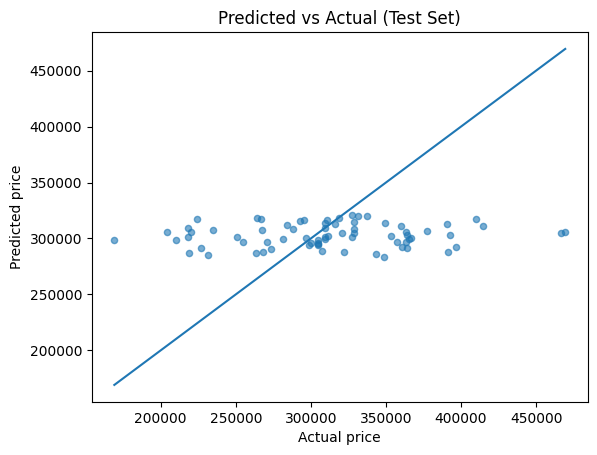

In [18]:
# --- Predicted vs Actual (test set) with 45° reference line ---
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

lo = float(min(y_test.min(), y_pred.min()))
hi = float(max(y_test.max(), y_pred.max()))

plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([lo, hi], [lo, hi])  # 45° reference line
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Predicted vs Actual (Test Set)')
plt.show()


**How to read it?**

Points near the line → good predictions.
Systematic patterns (e.g., under-predicting at high prices) → model misses nonlinearity or interactions.

## Optional Step: Linear Regression Graph - Price vs sqft with fitted line -

**Price vs sqft (others fixed)**  
Shows the model’s **partial relationship** between square footage and price.  
If real data looks curved while the line is straight, consider adding **nonlinear features** (e.g., `sqft²`) or trying **regularization / tree models** later.

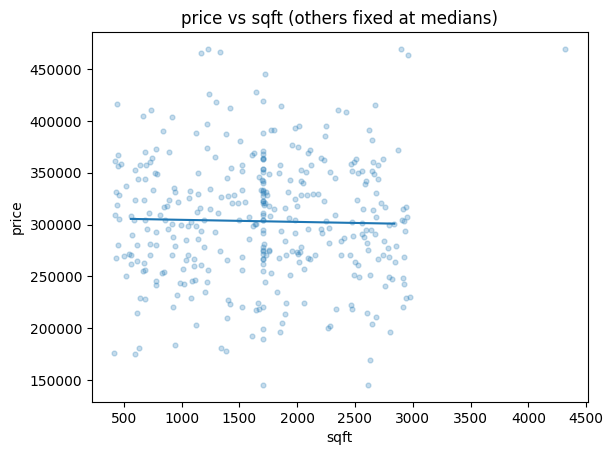

In [19]:
# --- Price vs sqft with fitted line (other features fixed at medians) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a single feature to visualize
feat = 'sqft'
# Fix the other features at their medians (partial dependence style)
fixed = X_train.median(numeric_only=True).to_dict()

# Build an evaluation grid for the chosen feature
x_grid = np.linspace(df[feat].quantile(0.05), df[feat].quantile(0.95), 200)
rows = []
for x in x_grid:
    row = fixed.copy()
    row[feat] = x
    rows.append(row)
X_line = pd.DataFrame(rows)[X_train.columns]  # ensure column order
y_line = model.predict(X_line)

# Scatter of actual data
plt.scatter(df[feat], df['price'], alpha=0.25, s=12)
# Fitted line
plt.plot(x_grid, y_line)
plt.xlabel(feat)
plt.ylabel('price')
plt.title(f'price vs {feat} (others fixed at medians)')
plt.show()


**How to read it?**

The line shows the model’s predicted relationship between sqft and price when other features are held constant.
If scatter trends curve but the line is straight, it hints the model might benefit from nonlinear terms or feature engineering.

### Interpreting the Regression Graph

The plot above shows the **relationship between `sqft` (square footage)** and **`price`**, while keeping all other features fixed at their median values.

#### What do we see?
- The blue scatter points are spread **randomly**, with **no clear upward or downward trend**.  
- The blue line — representing our model’s predicted price — is nearly **flat**, showing that the model found **no meaningful relationship** between house size and price.

#### Why does this happen?
This dataset is **synthetic** and was generated with random values for both features and prices.  
Because there’s no real pattern linking `sqft` to `price`:
- The model can’t find a statistically significant slope.  
- The regression line stays flat or even slightly sloped in the wrong direction.  
- The scatter plot looks noisy and unstructured, just like random data should.

#### Key takeaway
The graph correctly shows that the model didn’t learn any real relationship — because none exists in the data.

This is actually a **good demonstration**:
- It illustrates that **models only learn patterns that exist** in the data.  
- With realistic housing data, you’d expect to see a clear **positive relationship** — prices generally increasing as square footage increases.  
- Here, the randomness highlights the **importance of meaningful, well-structured data** for predictive modeling.

**In short:**  
The “flat” line isn’t an error — it’s evidence that the model did exactly what it was supposed to do: fit a line through random noise.


## Optional Step: Interactive Price Predictor

**Interactive predictor**  
Use the sliders to set house characteristics and see the **model’s predicted price**.  
This helps build intuition for how features influence the target in a linear model.

In [16]:
# --- Interactive predictor for Housing price (Linear Regression) ---

import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider, IntSlider

# Helper: make safe slider ranges from the cleaned data
def rng(col, qlow=0.01, qhigh=0.99):
    lo = float(df[col].quantile(qlow))
    hi = float(df[col].quantile(qhigh))
    if lo == hi:
        # fallback in degenerate cases
        lo, hi = float(df[col].min()), float(df[col].max())
    return lo, hi

# Build sliders dynamically from data quantiles (robust to outliers)
sqft_lo, sqft_hi = rng('sqft')
lot_lo, lot_hi   = rng('lot_size')
dist_lo, dist_hi = rng('dist_to_center_km')
age_lo, age_hi   = rng('age_years')

# Discrete counts
bed_lo, bed_hi   = int(df['bedrooms'].quantile(0.01)), int(df['bedrooms'].quantile(0.99))
bath_lo, bath_hi = int(df['bathrooms'].quantile(0.01)), int(df['bathrooms'].quantile(0.99))
bed_lo  = max(1, bed_lo)
bath_lo = max(1, bath_lo)

# Keep feature order consistent with training
feature_cols = list(X_train.columns)

def predict_price(
    sqft, bedrooms, bathrooms, age_years, lot_size, dist_to_center_km
):
    # Create a single-row input in the same column order as training
    Xnew = pd.DataFrame([{
        'sqft': sqft,
        'bedrooms': int(bedrooms),
        'bathrooms': int(bathrooms),
        'age_years': age_years,
        'lot_size': lot_size,
        'dist_to_center_km': dist_to_center_km
    }])[feature_cols]  # enforce same column order
    yhat = model.predict(Xnew)[0]
    print(f"💡 Predicted price: ${yhat:,.0f}")

interact(
    predict_price,
    sqft=FloatSlider(value=np.clip(df['sqft'].median(), sqft_lo, sqft_hi), min=sqft_lo, max=sqft_hi, step=10, description='sqft'),
    bedrooms=IntSlider(value=int(df['bedrooms'].median()), min=bed_lo, max=bed_hi, step=1, description='bedrooms'),
    bathrooms=IntSlider(value=int(df['bathrooms'].median()), min=bath_lo, max=bath_hi, step=1, description='bathrooms'),
    age_years=FloatSlider(value=np.clip(df['age_years'].median(), age_lo, age_hi), min=age_lo, max=age_hi, step=1, description='age_years'),
    lot_size=FloatSlider(value=np.clip(df['lot_size'].median(), lot_lo, lot_hi), min=lot_lo, max=lot_hi, step=float((lot_hi-lot_lo)/100), description='lot_size'),
    dist_to_center_km=FloatSlider(value=np.clip(df['dist_to_center_km'].median(), dist_lo, dist_hi), min=dist_lo, max=dist_hi, step=0.1, description='dist_km')
);


interactive(children=(FloatSlider(value=1705.0, description='sqft', max=2946.46, min=431.59, step=10.0), IntSl…

### A few observations about our results

#### Regression Graph Appearance
The **scatter plot and regression line** may also look unimpressive — the points are scattered randomly, and the line doesn’t clearly match any visible trend.  

Again, this is a direct consequence of our **synthetic (random) data**:
- There’s **no underlying relationship** between features and `price`, so the regression line appears nearly flat or even misleading.  
- The **Predicted vs Actual** graph will show a weak or noisy pattern with no clear alignment along the 45° reference line.

#### Interactive Tool Behavior
You might notice that the **interactive price predictor** doesn’t behave realistically — for example, increasing square footage sometimes *decreases* the predicted price.  

This happens because our **synthetic dataset** was generated randomly and doesn’t contain real-world relationships between features and `price`.  
As a result:
- The model finds **no true pattern** and assigns random coefficients to features.  
- Some coefficients can have **incorrect signs** (e.g., negative for `sqft`).  
- The interactive tool reflects exactly what the model learned — which, in this case, is noise.

**Important insight:**  
This “wrong behavior” is actually a great learning opportunity. It shows that the quality of your model depends entirely on the quality and structure of your data.

**Key takeaway:**  
The graphs and interactive tool are doing their job — they’re *revealing that the model didn’t learn a real pattern*.  
If you use structured or realistic data later (with true relationships), you’ll see stronger, more intuitive visuals and coefficients that make sense.